# Agent를 이용한 Corrective RAG

https://github.com/kyopark2014/langgraph-agent/blob/main/corrective-rag-agent.md

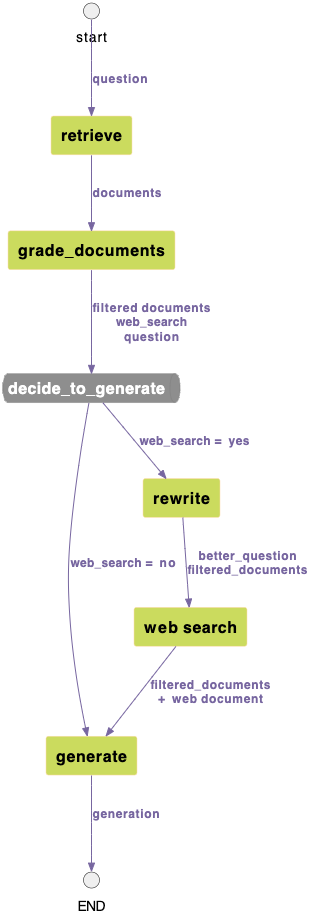

In [2]:
import boto3

In [3]:
!pip3 install langchain-aws langchain-community langchain --quiet

In [4]:
from botocore.config import Config
from langchain_aws import ChatBedrock
bedrock_region = 'us-east-1'
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=bedrock_region,
    config=Config(
        retries = {
            'max_attempts': 30
        }            
    )
)

HUMAN_PROMPT = "\n\nHuman:"
AI_PROMPT = "\n\nAssistant:"
maxOutputTokens = 4096
parameters = {
    "max_tokens":maxOutputTokens,     
    "temperature":0.1,
    "top_k":250,
    "top_p":0.9,
    "stop_sequences": [HUMAN_PROMPT]
}    
chat = ChatBedrock(   
    model_id=modelId,
    client=boto3_bedrock, 
    model_kwargs=parameters,
)

from langchain_community.embeddings import BedrockEmbeddings
embedding_model_id = "amazon.titan-embed-text-v2:0"
bedrock_embedding = BedrockEmbeddings(
    client=boto3_bedrock,
    region_name = bedrock_region,
    model_id = embedding_model_id
) 

In [5]:
from langchain.memory import ConversationBufferWindowMemory
memory_chain = ConversationBufferWindowMemory(memory_key="chat_history", output_key='answer', return_messages=True, k=10)

## Tavily Search

In [6]:
import getpass

api_key = getpass.getpass("Password:")

Password: ········


In [7]:
import os
os.environ["TAVILY_API_KEY"] = api_key

In [8]:
!pip install -U tavily-python --quiet

In [9]:
langsmith_api_key = getpass.getpass("Password:")

Password: ········


In [10]:
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Corrective-RAG"

In [11]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
            "다음의 Human과 Assistant의 친근한 이전 대화입니다."
            "Assistant은 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다."
            "Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
chain = prompt | chat

msg = ""
request = HumanMessage(
    content="이미지를 분석하기 위한 서비스에 대해 설명해줘."
)

output = chain.stream({"messages": [request]})
for event in output:
    print(event.content, end="")
    msg += event.content
    
msg

안녕하세요. 이미지 분석 서비스에 대해 설명해 드리겠습니다. 이미지 분석 서비스는 컴퓨터 비전과 머신러닝 기술을 활용하여 이미지에서 다양한 정보를 추출하고 분석하는 서비스입니다. 

주요 기능으로는 객체 인식, 얼굴 인식, 텍스트 인식, 이미지 분류, 콘텐츠 모더레이션 등이 있습니다. 객체 인식은 이미지 내에 있는 사물이나 사람 등의 객체를 인식하고 레이블을 붙입니다. 얼굴 인식은 이미지에서 사람의 얼굴을 찾아내고 연령, 감정 등의 속성을 분석합니다.

텍스트 인식은 이미지 내 텍스트 영역을 찾아 텍스트를 추출합니다. 이미지 분류는 이미지의 주제나 카테고리를 자동으로 분류합니다. 콘텐츠 모더레이션은 부적절한 콘텐츠를 필터링하는 데 사용됩니다.

이런 기능들을 활용하면 이미지에서 유용한 인사이트를 얻을 수 있습니다. 예를 들어 제품 카탈로그에서 제품을 자동 태깅하거나, 소셜 미디어에서 부적절한 콘텐츠를 필터링하는 등 다양한 분야에 적용할 수 있습니다.

'안녕하세요. 이미지 분석 서비스에 대해 설명해 드리겠습니다. 이미지 분석 서비스는 컴퓨터 비전과 머신러닝 기술을 활용하여 이미지에서 다양한 정보를 추출하고 분석하는 서비스입니다. \n\n주요 기능으로는 객체 인식, 얼굴 인식, 텍스트 인식, 이미지 분류, 콘텐츠 모더레이션 등이 있습니다. 객체 인식은 이미지 내에 있는 사물이나 사람 등의 객체를 인식하고 레이블을 붙입니다. 얼굴 인식은 이미지에서 사람의 얼굴을 찾아내고 연령, 감정 등의 속성을 분석합니다.\n\n텍스트 인식은 이미지 내 텍스트 영역을 찾아 텍스트를 추출합니다. 이미지 분류는 이미지의 주제나 카테고리를 자동으로 분류합니다. 콘텐츠 모더레이션은 부적절한 콘텐츠를 필터링하는 데 사용됩니다.\n\n이런 기능들을 활용하면 이미지에서 유용한 인사이트를 얻을 수 있습니다. 예를 들어 제품 카탈로그에서 제품을 자동 태깅하거나, 소셜 미디어에서 부적절한 콘텐츠를 필터링하는 등 다양한 분야에 적용할 수 있습니다.'

In [12]:
!pip install faiss-cpu --quiet

In [13]:
# English URL
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

In [14]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores.faiss import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Korean URL
#urls = [
#    "https://docs.aws.amazon.com/ko_kr/bedrock/latest/userguide/what-is-bedrock.html",
#    "https://docs.aws.amazon.com/ko_kr/athena/latest/ug/what-is.html",
#    "https://docs.aws.amazon.com/ko_kr/athena/latest/ug/glue-athena.html"
#]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [15]:
doc_splits[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content="LLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n 

In [16]:
# Add to vectorDB
vectorstore = FAISS.from_documents(
    doc_splits,
    bedrock_embedding,
)
retriever = vectorstore.as_retriever()

In [17]:
from langchain_core.pydantic_v1 import BaseModel, Field

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

structured_llm_grader = chat.with_structured_output(GradeDocuments)

### Grade Prompt

In [18]:
# Prompt 
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [19]:
retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)

In [20]:
doc_txt = docs[1].page_content
doc_txt

'Short-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model to learn.\nLong-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.\n\n\nTool use\n\nThe agent learns to call external APIs for extra information that is missing from the model weights (often hard to change after pre-training), including current information, code execution capability, access to proprietary information sources and more.'

In [21]:
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### RAG Prompt

In [22]:
system = (
#"""다음의 <context> tag안의 참고자료를 이용하여 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다. Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.
"""Here is pieces of context, contained in <context> tags. Provide a concise answer to the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.
                        
<context>
{context}
</context>""")
human = "{question}"
    
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])
                   
rag_chain = prompt | chat

In [23]:
# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

content="Based on the context provided, there are a few key points about memory in LLM-powered autonomous agents:\n\n1. Short-term memory is utilized through in-context learning and prompt engineering, allowing the LLM to learn and use information from the current context/prompt.\n\n2. Long-term memory is enabled by leveraging an external vector store or database to retain and retrieve large amounts of information over extended periods.\n\n3. The memory stream is a long-term memory module that records a comprehensive list of the agent's experiences in natural language format.\n\n4. A retrieval model surfaces relevant context from the memory stream to inform the agent's behavior, considering factors like recency, importance, and relevance to the current situation.\n\n5. A reflection mechanism synthesizes memories into higher-level inferences and summaries to guide the agent's future behavior.\n\nSo in summary, these agents have short-term memory via prompts, long-term memory via externa

### ReWrite Prompt

In [24]:
class RewriteQuestion(BaseModel):
    """rewrited question that is well optimized for retrieval."""

    question: str = Field(description="The new question is optimized for web search")
    
structured_llm_rewriter = chat.with_structured_output(RewriteQuestion)

In [25]:
# Prompt 
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Here is the initial question: \n\n {question} \n Formulate an improved question."),
    ]
)

In [26]:
question_rewriter = re_write_prompt | structured_llm_rewriter
question = "agent memory"
print(question_rewriter.invoke({"question": question}))

question='What is agent memory and how does it work in artificial intelligence systems?'


## Graph state

In [27]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    question : str
    generation : str
    web_search : str
    documents : List[str]

In [28]:
from langchain.schema import Document

def retrieve(state: GraphState):
    print("###### retrieve ######")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    print("document[0]: ", documents[0])
    
    return {"documents": documents, "question": question}

In [29]:
def grade_documents(state: GraphState):
    print("###### grade_documents ######")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for doc in documents:
        score = retrieval_grader.invoke({"question": question, "document": doc.page_content})
        grade = score.binary_score
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(doc)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    print('len(docments): ', len(filtered_docs))
    print('web_search: ', web_search)
    
    return {"question": question, "documents": filtered_docs, "web_search": web_search}

In [30]:
def decide_to_generate(state: GraphState):
    print("###### decide_to_generate ######")
    web_search = state["web_search"]
    
    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "rewrite"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [31]:
def generate(state: GraphState):
    print("###### generate ######")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    print('generation: ', generation.content)
    
    return {"documents": documents, "question": question, "generation": generation}

In [32]:
def rewrite(state: GraphState):
    print("###### rewrite ######")
    question = state["question"]
    documents = state["documents"]

    # Prompt
    better_question = question_rewriter.invoke({"question": question})
    print("better_question: ", better_question.question)

    return {"question": better_question.question, "documents": documents}

In [33]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [34]:
def web_search(state: GraphState):
    print("###### web_search ######")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    
    return {"question": question, "documents": documents}

### Build Graph

In [35]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("rewrite", rewrite)
workflow.add_node("websearch", web_search)

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "rewrite": "rewrite",
        "generate": "generate",
    },
)
workflow.add_edge("rewrite", "websearch")
workflow.add_edge("websearch", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

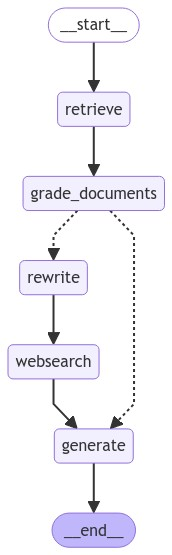

In [36]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [37]:
from pprint import pprint
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

###### retrieve ######
document[0]:  page_content='Fig. 7. Comparison of AD, ED, source policy and RL^2 on environments that require memory and exploration. Only binary reward is assigned. The source policies are trained with A3C for "dark" environments and DQN for watermaze.(Image source: Laskin et al. 2023)
Component Two: Memory#
(Big thank you to ChatGPT for helping me draft this section. I’ve learned a lot about the human brain and data structure for fast MIPS in my conversations with ChatGPT.)
Types of Memory#
Memory can be defined as the processes used to acquire, store, retain, and later retrieve information. There are several types of memory in human brains.


Sensory Memory: This is the earliest stage of memory, providing the ability to retain impressions of sensory information (visual, auditory, etc) after the original stimuli have ended. Sensory memory typically only lasts for up to a few seconds. Subcategories include iconic memory (visual), echoic memory (auditory), and ha

In [38]:
inputs = {"question": "How does the AlphaCodium paper work?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

###### retrieve ######
document[0]:  page_content='where $\lambda_\text{LLM}$ is a hyperparameter instead of a variable. And we have $\log p ( \mathbf{y} \mid \mathbf{x}) = \sum_{i=1}^n p(y_i \mid x, y_1, \dots, y_{i-1})$.
The coordinate ascent algorithm of ARCA updates only one token at index $i$ at each step to maximize the above objective, while other tokens are fixed. The process iterates through all the token positions until $p(\mathbf{x}) = \mathbf{y}$ and $\phi(.) \geq \tau$, or hit the iteration limit.
Let $v \in \mathcal{V}$ be the token with embedding $\mathbf{e}_v$ that maximizes the above objective for the $i$-th token $y_i$ in the output $\mathbf{y}$ and the maximized objective value is written as:' metadata={'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/', 'title': "Adversarial Attacks on LLMs | Lil'Log", 'description': 'The use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at 

In [39]:
inputs = {"question": "Aver의 Glue는 무엇이지?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

###### retrieve ######
document[0]:  page_content='Short-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model to learn.
Long-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.


Tool use

The agent learns to call external APIs for extra information that is missing from the model weights (often hard to change after pre-training), including current information, code execution capability, access to proprietary information sources and more.' metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The pot